# Sumowanie liczb pojedynczej precyzji

In [1]:
import numpy as np
from random import uniform
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
NUM = np.float64(uniform(0.1, 0.9))
ARR = np.full(int(1e7), NUM, dtype=np.float32)
REAL_RESULT = np.float64(NUM*1e7)
print(f"liczba, która będzie wykorzystywana do testów: {NUM:.60f}")

liczba, która będzie wykorzystywana do testów: 0.577905659784310521409622651844983920454978942871093750000000


In [3]:
def naive_sum(arr, use_float64=False):
    if use_float64:
        s = np.float64(0)
    else:
        s = np.float32(0)
    for i in arr:
        s += i
    assert type(s)==np.float32 or use_float64
    return s
naive = naive_sum(ARR)
real = 1e7*NUM
print(f"summing result: {naive} | real result: {real}")

summing result: 5332520.0 | real result: 5779056.597843105


In [4]:
def error(res, res_true):
    return abs(res - res_true)
    
def rel_error(res, res_true):
    return error(res, res_true)/res_true

print(f"error: {error(naive, REAL_RESULT):.4f} | relative error: {100*rel_error(naive, REAL_RESULT):.2f}%")

error: 446536.5978 | relative error: 7.73%


Uzyskane (zaokrąglone) wyniki przy użyciu sumowania prostego:

Sumowana liczba | Błąd względny \[%\] | Błąd bezwzględny
--- | --- | ---
0.51835 | 3.08 | 159812
**0.53125** | **5.30** | **281659**
0.57790 | 7.73 | 446536
0.22312 | 8.87 | 197801
0.58953 | 9.26 | 545747
0.37242 | 14.1 | 525602

Błąd względy jest duży (rzędu kilku procent) ze względu na wykorzystanie do sumowania akumulatora, który przetrzymuje aktualny wynik sumy w danej iteracji. Sumowana liczba jest wielokrotnie dodawana do akumulatora przez co pod koniec wykonywania algorytmu dodawane liczby skrajnie różnią się rzędami wielkości (wartość akumulatora wynosi ponad $10^6$, a dodawana liczba jest mniejsza niż 1).  
Ze względu na stałą wielkość mantysy może ona przechowywać tylko ograniczoną liczbę cyfr znaczących, co wymusza odrzucenie najmniej znaczącej części wyniku - w skrajnym przypadku całej liczby dodawanej - powoduje to, że uzyskany wynik odbiega od oczekiwanego.

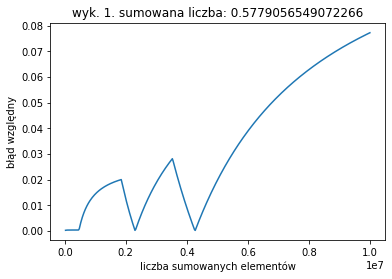

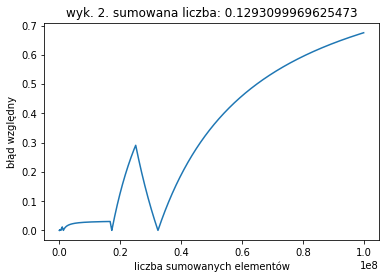

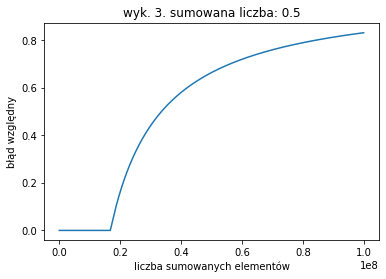

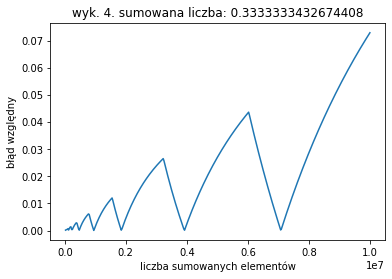

In [5]:
def error_plot(num, sum_to=int(1e7), wyk=0):
    errors_32 = []
    x_values = [x for x in range(25000, int(sum_to)+1, 25000)]
    y_32 = np.float32(0)
    num = np.float32(num)
    for i in range(1, int(sum_to)+1):
        y_32 += num
        if i%25000==0:
            real_y = num * i
            errors_32.append(rel_error(y_32, real_y))
    plt.plot(x_values, errors_32)
    plt.title(f"wyk. {wyk}. sumowana liczba: {num}")
    plt.ylabel("błąd względny")
    plt.xlabel("liczba sumowanych elementów")
    plt.show()


error_plot(NUM, wyk=1)
error_plot(0.12931, sum_to=int(1e8), wyk=2)
error_plot(0.5, sum_to=int(1e8), wyk=3)
error_plot(sum([1/2**i for i in range(1,50) if i%2==0]), wyk=4)

W trakcie sumowania przypadkowych liczb (wykresy 1 i 2) z zakresu \[0.1, 0.9\] błąd względny początkowo utrzymuje się na stałym poziomie lub rośnie/spada w sposób nieregularny, a od pewnej wartości zacząć monotonicznie wzrastać zbliżając się do wartości 1.  

Uważam, że to pseudo-chaotyczne zachowanie spowodowane jest tym, że dodawana to akumulatora liczba jest różnie zaokrąglana w zależności od tego czy najstarczy odrzucony bit tej liczby miał wartość 0 (zaokgrąglanie w dół) czy 1 (zaokrąglanie w górę). Przekonanie to popieram wykresami 3 i 4. Sumowane na wykresie 3 liczba 0.5 nie powoduje początkowego nieregularnego zachowania, ponieważ ze względu na odwzorowanie liczby 0.5 jej zaokrąglenie może spowodować tylko wzrost błędu (jej zaokrąglenie może zmienić ją tylko w 0). Z kolei na wykresie 4 mantysa sumowanej liczby składa się z naprzemiennie występująch 0 i 1 - dodawana liczba jest więc raz zaokrąglana w górę, a raz w dół co powoduje regularne wzrastanie i opadanie błędu.


In [6]:
def recursive_sum(arr):
    l = len(arr)
    if l==1:
        return arr[0]
    elif l==2:
        return arr[0] + arr[1]
    return recursive_sum(arr[:l//2]) + recursive_sum(arr[l//2:])

rec = recursive_sum(ARR)
assert type(rec) == np.float32
print(f"error: {error(rec, REAL_RESULT):.4f} | relative error: {100*rel_error(rec, REAL_RESULT):.8f}%")

error: 0.4022 | relative error: 0.00000696%


Uzyskane (zaokrąglone) wyniki przy użyciu sumowania rekurencyjnego:

Sumowana liczba | Błąd względny \[%\] | Błąd bezwzględny
--- | --- | ---
0.58953 | 0.00000256 | 0.1511
0.80699 | 0.00000345 | 0.2786
0.48874 | 0.00000580 | 0.2834
0.57790 | 0.00000696 | 0.4022

Rekurencyjne sumowanie sprawia, że sumowane liczby są prawie zawsze sumą takiej samej ilości elementów. Pozwala to na uniknięcie sytuacji w której dodawane są liczby o różnych rzędach wielkości (w tym konkrentym przypadku cechy dodawanych liczb powinny zawsze być identyczne) - ilość liczb znczących przechowywanych w mantysie jest maksymalnie wykorzystywana.  

## Porównanie czasów działania

In [7]:
%%timeit
naive_sum(ARR)

2.57 s ± 613 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
recursive_sum(ARR)

9.1 s ± 591 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Zmierzone czasy działania obu algorytmów dla tablicy zawierającej $10^7$ elementów

Algorytm | Czas działania\[s\] | Odchylenie standardowe \[ms\]
:---: | --- | ---
sumowanie proste | 2.57 | 613
sumowanie rekurencyjne | 9.1 | 591 

Algorymt korzystający z rekurencji działa zdecydowanie dłużej ze względnu na jego większą złożonosć obliczeniową

## Przykładowe niekorzystne dane dla algorytmu rekurencyjnego

In [21]:
arr = np.zeros((10,), dtype=np.float64)
arr[:] = 1e8
arr[0] = 1e-8
res = recursive_sum(arr)
l = arr.shape[0]
print(f"result: {res:.10f}")

result: 900000000.0000000000


Dla tablicy 10-elementowej wypełnionej 9 wartościami $10^8$ i jedną wartością $10^{-8}$ wynik powinien wynieść 900000000.00000001, lecz algorytm zwraca 900000000 - jest to oczywiście wynik błędny. Innym przykładem danych dla których algorytm zwróciłby zły wynik mogłaby być posortowana tablica.  

# Algorytm Kahana

In [10]:
def kahan(arr):
    s = np.float32(0)
    err = np.float32(0)
    for x in arr:
        y = x - err
        tmp = s + y  # tmp - s = y
        err = (tmp - s) - y
        s = tmp
    assert type(s) == np.float32
    return s

In [11]:
s = kahan(ARR)
print(f"error: {error(s, REAL_RESULT):.8f} |",
      f"relative error: {100*rel_error(s, REAL_RESULT):.10f}%")

error: 0.09784310 | relative error: 0.0000016931%


Uzyskane (zaokrąglone) wyniki przy zastosowaniu algorytmu Kahana:


Sumowana liczba | Błąd względny \[%\] | Błąd bezwzględny
--- | --- | ---
0.53125 | 0 | 0 
0.57790 | 0.000001693 | 0.09784
0.80699 | 0.000002743 | 0.22136


Algorytm Kahana uzyskuje mniejsze błędy niż poprzednie algorytmy.

Lepsze właściwości numeryczne algorytmu Kahana zachodzą dzięki obliczaniu i zapisywaniu (przybliżenia) powstającego w nim błędu. Jest to osiągnięte przez wprowadzenie zmiennej `err`, która służy do przechowywania sumy aktualnego błędu.   

W każdym kroku algorytmu błąd jest obliczany poprzez odjęcie od aktualnej sumy (`temp`) tej z poprzedniego kroku (`sum`) oraz aktualnie dodawanego elementu `y` - wynik ten pozwala uzyskać różnicę między częścią `y` rzeczywiście dodaną do sumy i rzeczywistą wartością `y`. 
Zmienna `err` jest używana do zmodyfikowania każdego dodawanego elementu (`x`) - dzięki temu przy każdej dodanej liczbie następuje próba poprawy aktualnej sumy o `err`. Jeżeli błąd urósł wystarczająco to przechowywane liczby znaczące zmiennych `err` i `sum` częściowo się pokryją, więc część błędu zostanie dodana do sumy.

## Porównanie czasów działania

In [12]:
%%timeit
recursive_sum(ARR)

9.11 s ± 652 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
kahan(ARR)

7.72 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Zmierzone czasy działania algorytmów dla tablicy zawierającej $10^7$ elementów

Algorytm | Czas działania\[s\] | Odchylenie standardowe \[ms\]
:---: | --- | ---
Rekurencja | 9.11 | 652
Kahan | 7.72 | 336

Algorytm Kahana jest zauważalnie szybszy od rekurencyjnego.

# Sumy częściowe

In [14]:
def dzeta_part(k, s, float32=True):
    if float32: return np.float32(1/k**s)
    return 1/k**s

def dzeta(s, n, forward=True, float32=True):
    if float32:
        v = np.float32(0)
    else:
        v = np.float64(0)
    
    if forward:
        generator = range(1,n+1)
    else:
        generator = range(n,0, -1)

    for k in generator:
        v += dzeta_part(k, s, float32)
    assert type(v)==np.float32 or not float32
    return v


def diri_part(k, s, float32=True):
    if float32: return np.float32((-1)**(k-1)*1/k**s)
    return (-1)**(k-1)*1/k**s

def diri(s, n, forward=True, float32=True):
    if float32:
        v = np.float32(0)
    else:
        v = np.float64(0)
    
    if forward:
        generator = range(1,n+1)
    else:
        generator = range(n,0, -1)

    for k in generator:
        v += diri_part(k, s, float32)
    assert type(v)==np.float32 or not float32
    return v

In [15]:
def show_array(arr, title, ax, i, j):
    ax[i][j].imshow(arr)
    ax[i][j].set_xticklabels([""] + n_list)
    ax[i][j].set_yticklabels([""] + s_list)
    for x in range(5):
        for y in range(5):
            text = ax[i][j].text(x, y, f"{arr[y, x]:.2E}",
                           ha="center", va="center", color="black")
    ax[i][j].set_title(title)
    ax[i][j].set_ylabel("s")
    ax[i][j].set_xlabel("n")

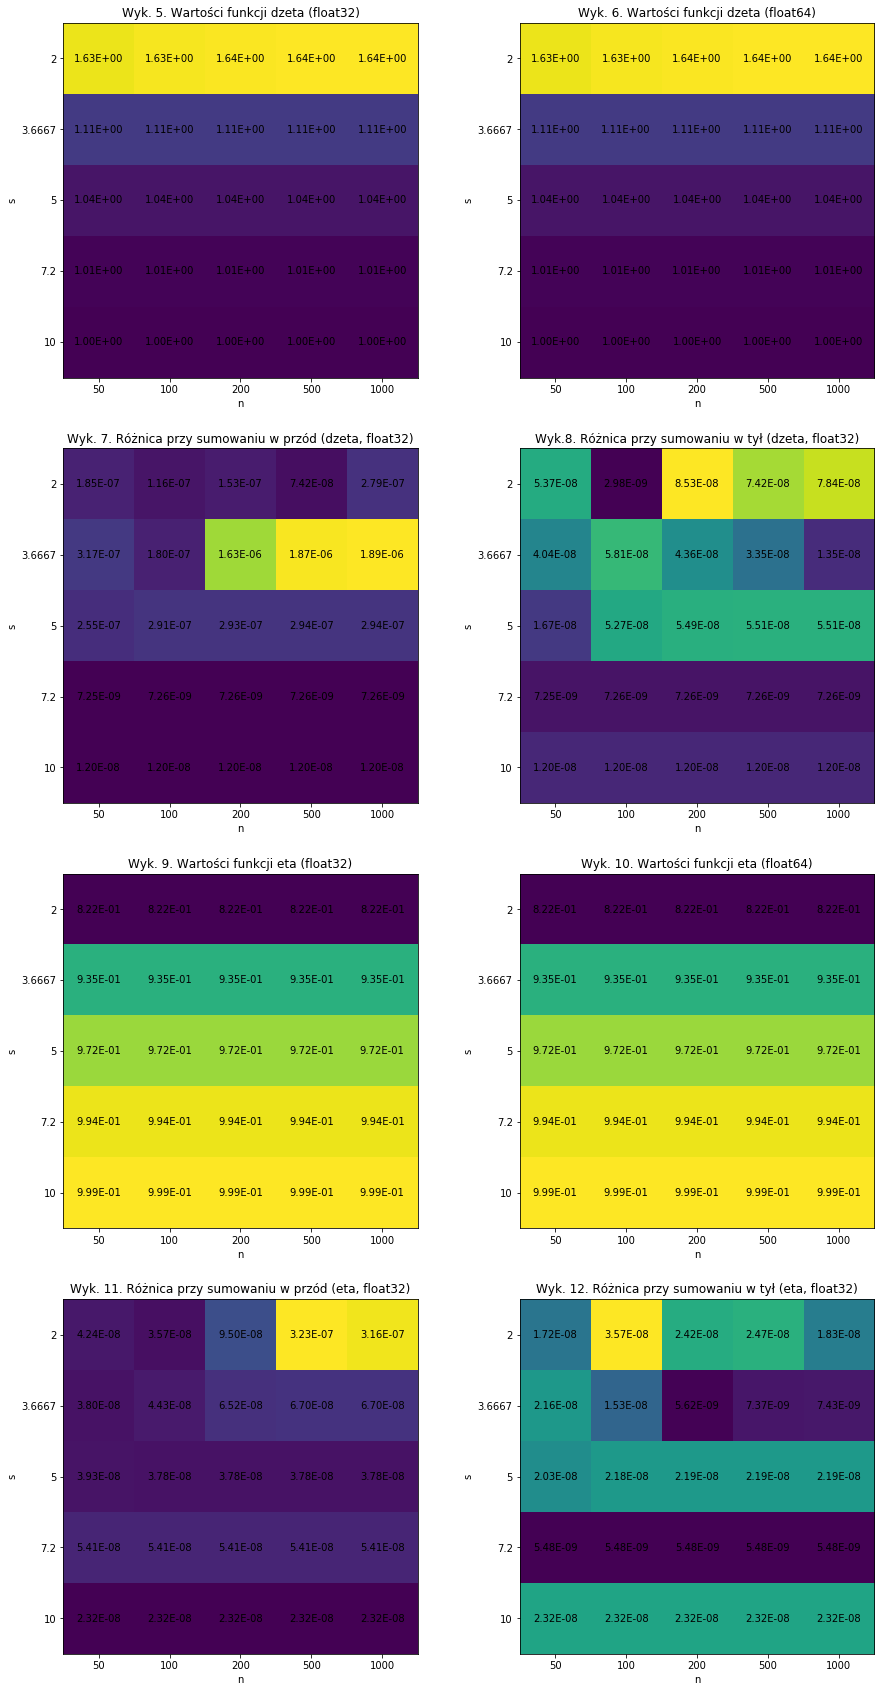

In [16]:
s_list = [2, 3.6667, 5, 7.2, 10]
n_list = [50, 100, 200, 500, 1000]
diff_forward = np.zeros((5,5), dtype=np.float64)
diff_backward = np.zeros((5,5), dtype=np.float64)
function_64 = np.zeros((5,5), dtype=np.float64)
function_32 = np.zeros((5,5), dtype=np.float64)
for i, s in enumerate(s_list):
    for j, n in enumerate(n_list):
        forward_32 = dzeta(s,n, forward=True)
        backward_32 = dzeta(s,n, forward=False)
        forward_64 = dzeta(s,n, forward=True, float32=False)
        backward_64 = dzeta(s,n, forward=False, float32=False)
        diff_forward[i, j] = abs(forward_64-forward_32)
        diff_backward[i, j] = abs(backward_64-backward_32)
        function_64[i, j] = backward_64
        function_32[i, j] = backward_32
        
fig, ax = plt.subplots(4, 2, figsize=(15,30))
show_array(function_32,"Wyk. 5. Wartości funkcji dzeta (float32)", ax, 0, 0)
show_array(function_64,"Wyk. 6. Wartości funkcji dzeta (float64)", ax, 0, 1)
show_array(diff_forward, "Wyk. 7. Różnica przy sumowaniu w przód (dzeta, float32)", ax, 1, 0)
show_array(diff_backward, "Wyk.8. Różnica przy sumowaniu w tył (dzeta, float32)", ax, 1, 1)

for i, s in enumerate([2, 3.6667, 5, 7.2, 10]):
    for j, n in enumerate([50, 100, 200, 500, 1000]):
        forward_32 = diri(s,n, forward=True)
        backward_32 = diri(s,n, forward=False)
        forward_64 = diri(s,n, forward=True, float32=False)
        backward_64 = diri(s,n, forward=False, float32=False)
        diff_forward[i, j] = abs(forward_64-forward_32)
        diff_backward[i, j] = abs(backward_64-backward_32)
        function_64[i, j] = backward_64
        function_32[i, j] = backward_32
        
show_array(function_32, "Wyk. 9. Wartości funkcji eta (float32)", ax, 2, 0)
show_array(function_64, "Wyk. 10. Wartości funkcji eta (float64)", ax, 2, 1)
show_array(diff_forward, "Wyk. 11. Różnica przy sumowaniu w przód (eta, float32)", ax, 3, 0)
show_array(diff_backward, "Wyk. 12. Różnica przy sumowaniu w tył (eta, float32)", ax, 3, 1)
plt.show()

Obliczone sumy częściowe funkcji dzeta Riemanna i eta Dirichleta różnią się w zależności od kolejności sumowania wyrazów. Na wykresach 9, 10, 11, 12 przedstawiono błąd bezwzględny między dokładnymi wartościami (jako dokładną przyjęto reprezentację korzystającą z podwójnej precyzji) sum częściowych, a wartościami uzyskanymi przy sumowaniu w przód/tył i użyciu pojedynczej precyzji.  

Błąd uzyskany przy sumowaniu w tył jest za każdym razem mniejszy lub taki sam jak przy sumowaniu w przód. Takie same błędy są generowane najprawdopodobniej gdy kolejne dodawane wyrazy różnią się na tyle, że jeden z nich musi być zaokrąglony do 0 ($s\geq7.2$) - w takim wypadku kierunek sumowania jest bez znaczenia.  

Podczas sumowania od przodu błąd jest większy ponieważ wartość sumy rośnie, a dodawany element maleje - różnica w rzędzie wielkości liczb stopniowo zwiększa się, więc odrzucane zostają coraz większe części liczby dodawanej.  

Sumowanie od tyłu zachowuje większą dokładność, ponieważ wartość sumy rośnie wraz z dodawanymi elementami - dzięki temu cechy dodawanych liczb są podobnej wielkości, a co za tym idzie mniej bitów z mantysy dodawanego elementu musi zostać odrzuconych.

Różnicę w wielkościach sumy i dodawanego elementu widać także przy porównaniu funkjci dzeta i eta. Funkcja eta generuje mniejszy błąd, ponieważ co drugi jej element jest taki sam jak odpowiedni element funkcji dzeta, lecz ujemny - wartość sumy rośnie przez to wolniej, więc różnica w wielkości sumy i dodawanego do niej elementu jest mniejsza (a co za tym idzie potrzeba jakiegokolwiek zaokrąglania nadchodzi później).

# Błędy zaokrągleń i odwzorowanie logistyczne

In [17]:
def next_term(prev, r):
    return r*prev*(1-prev)

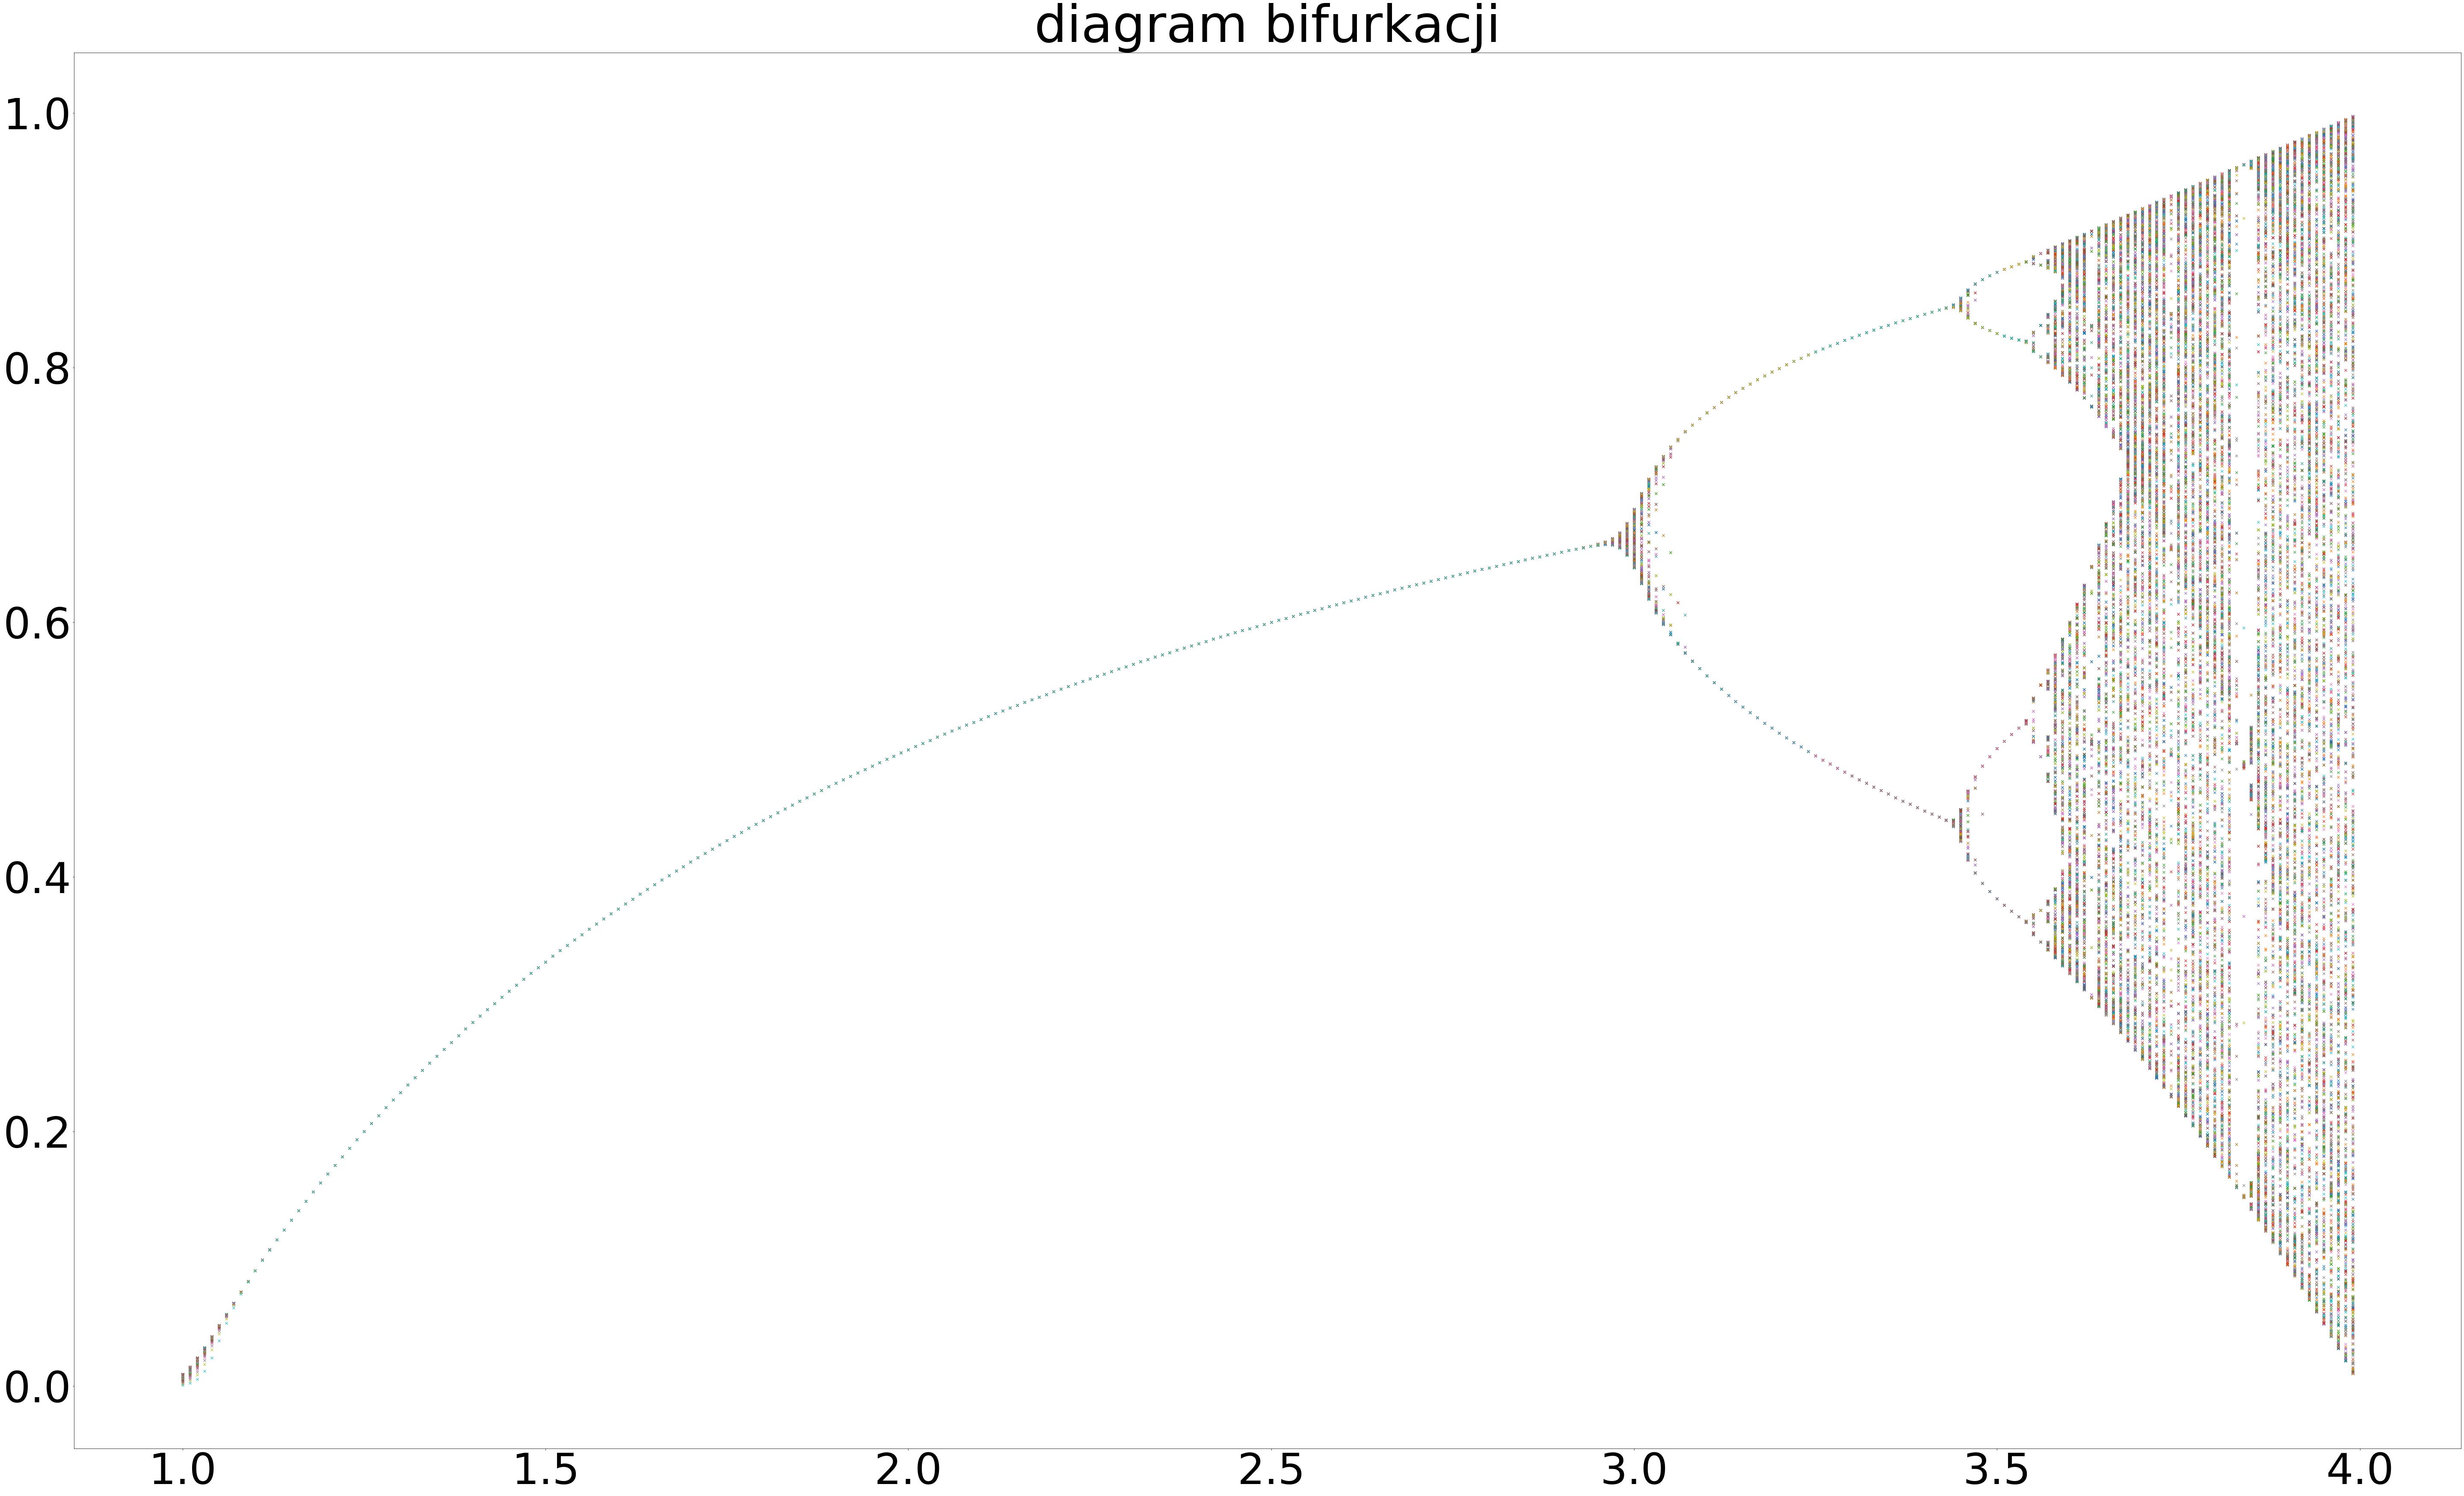

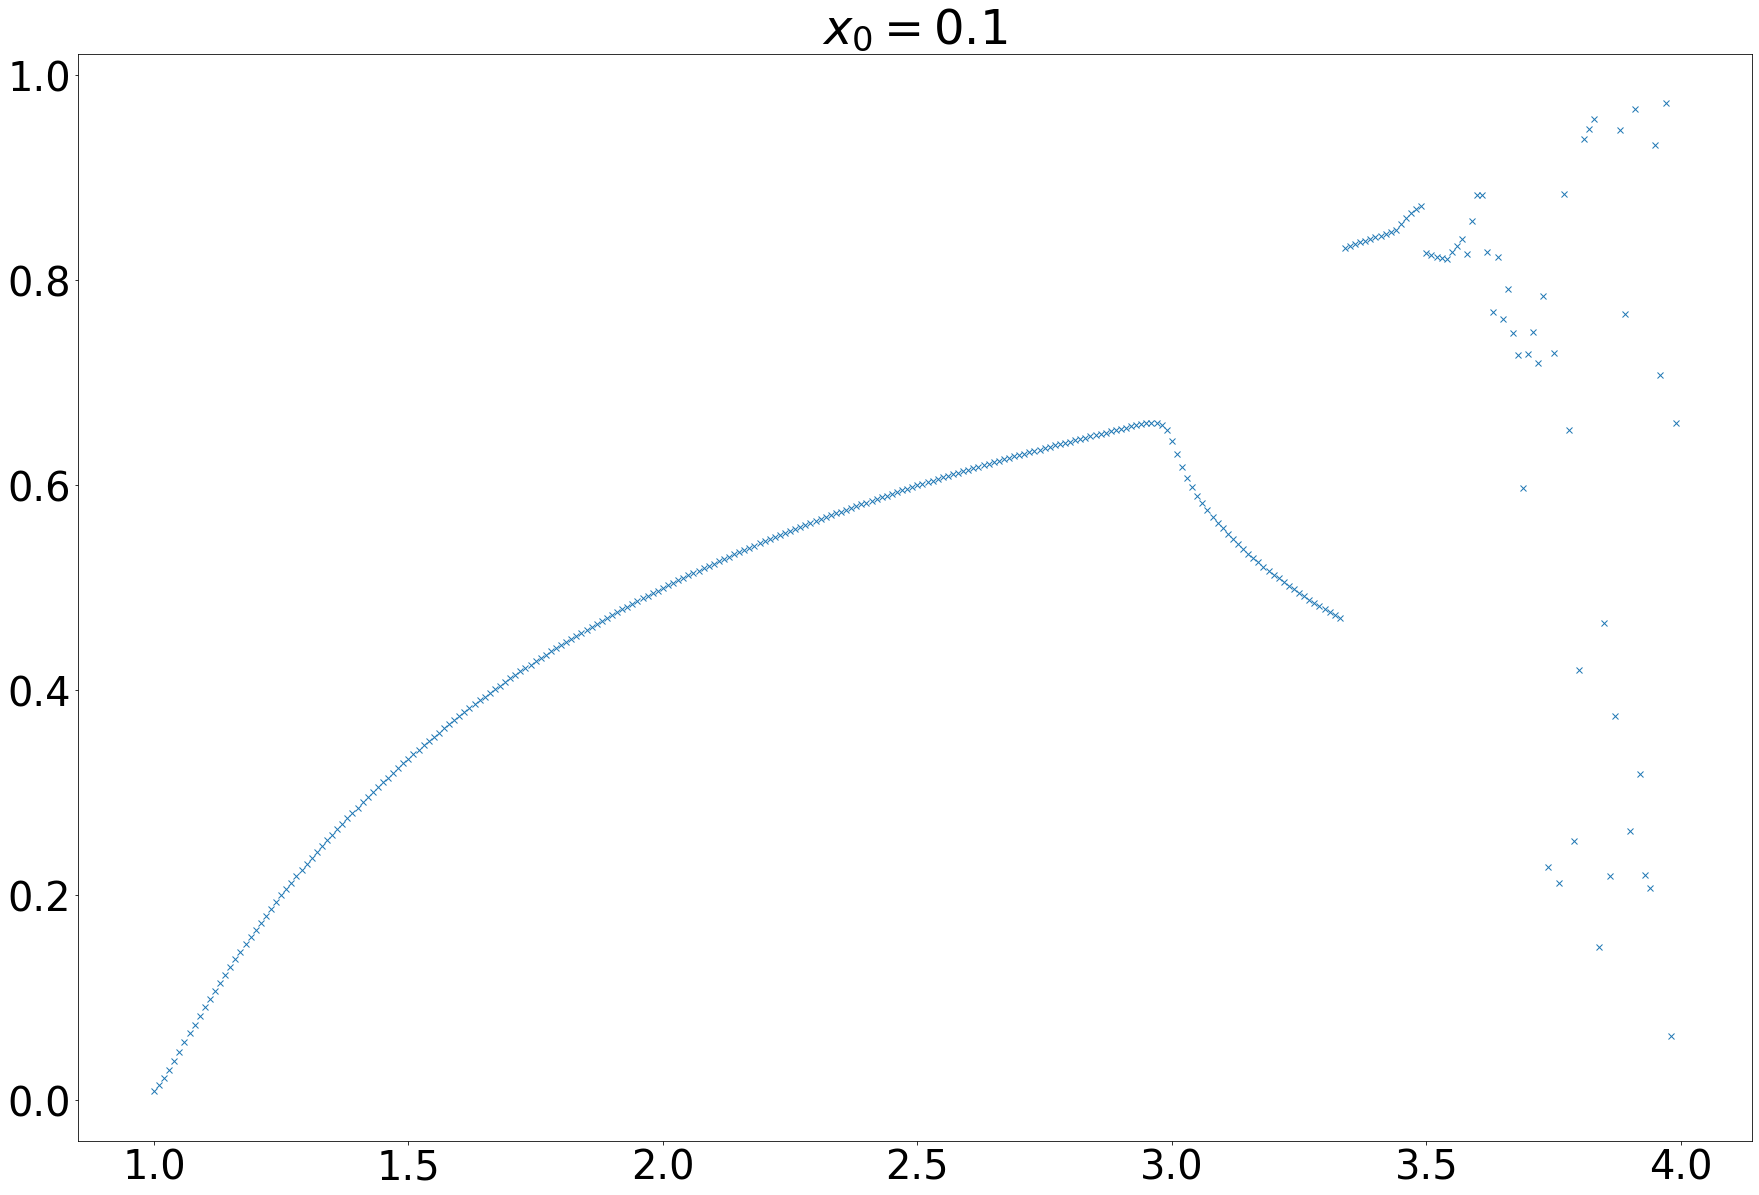

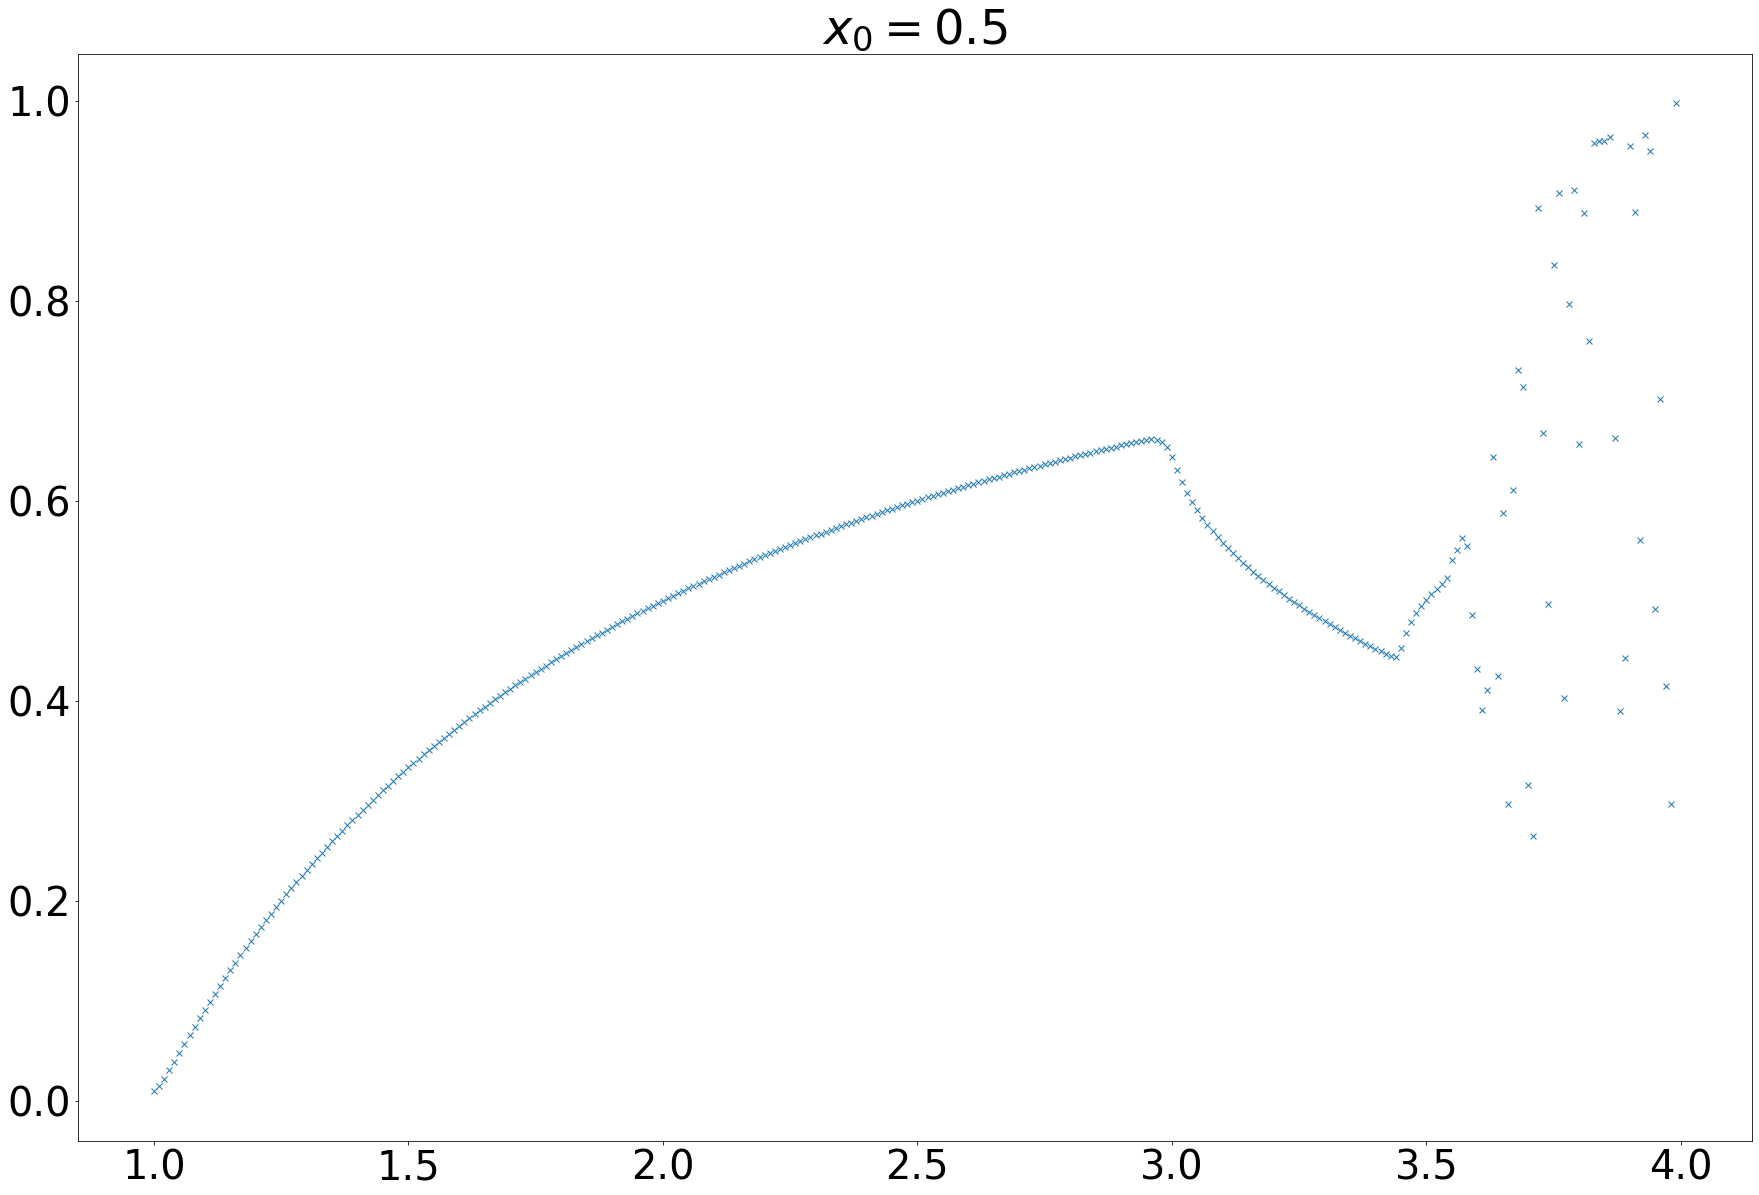

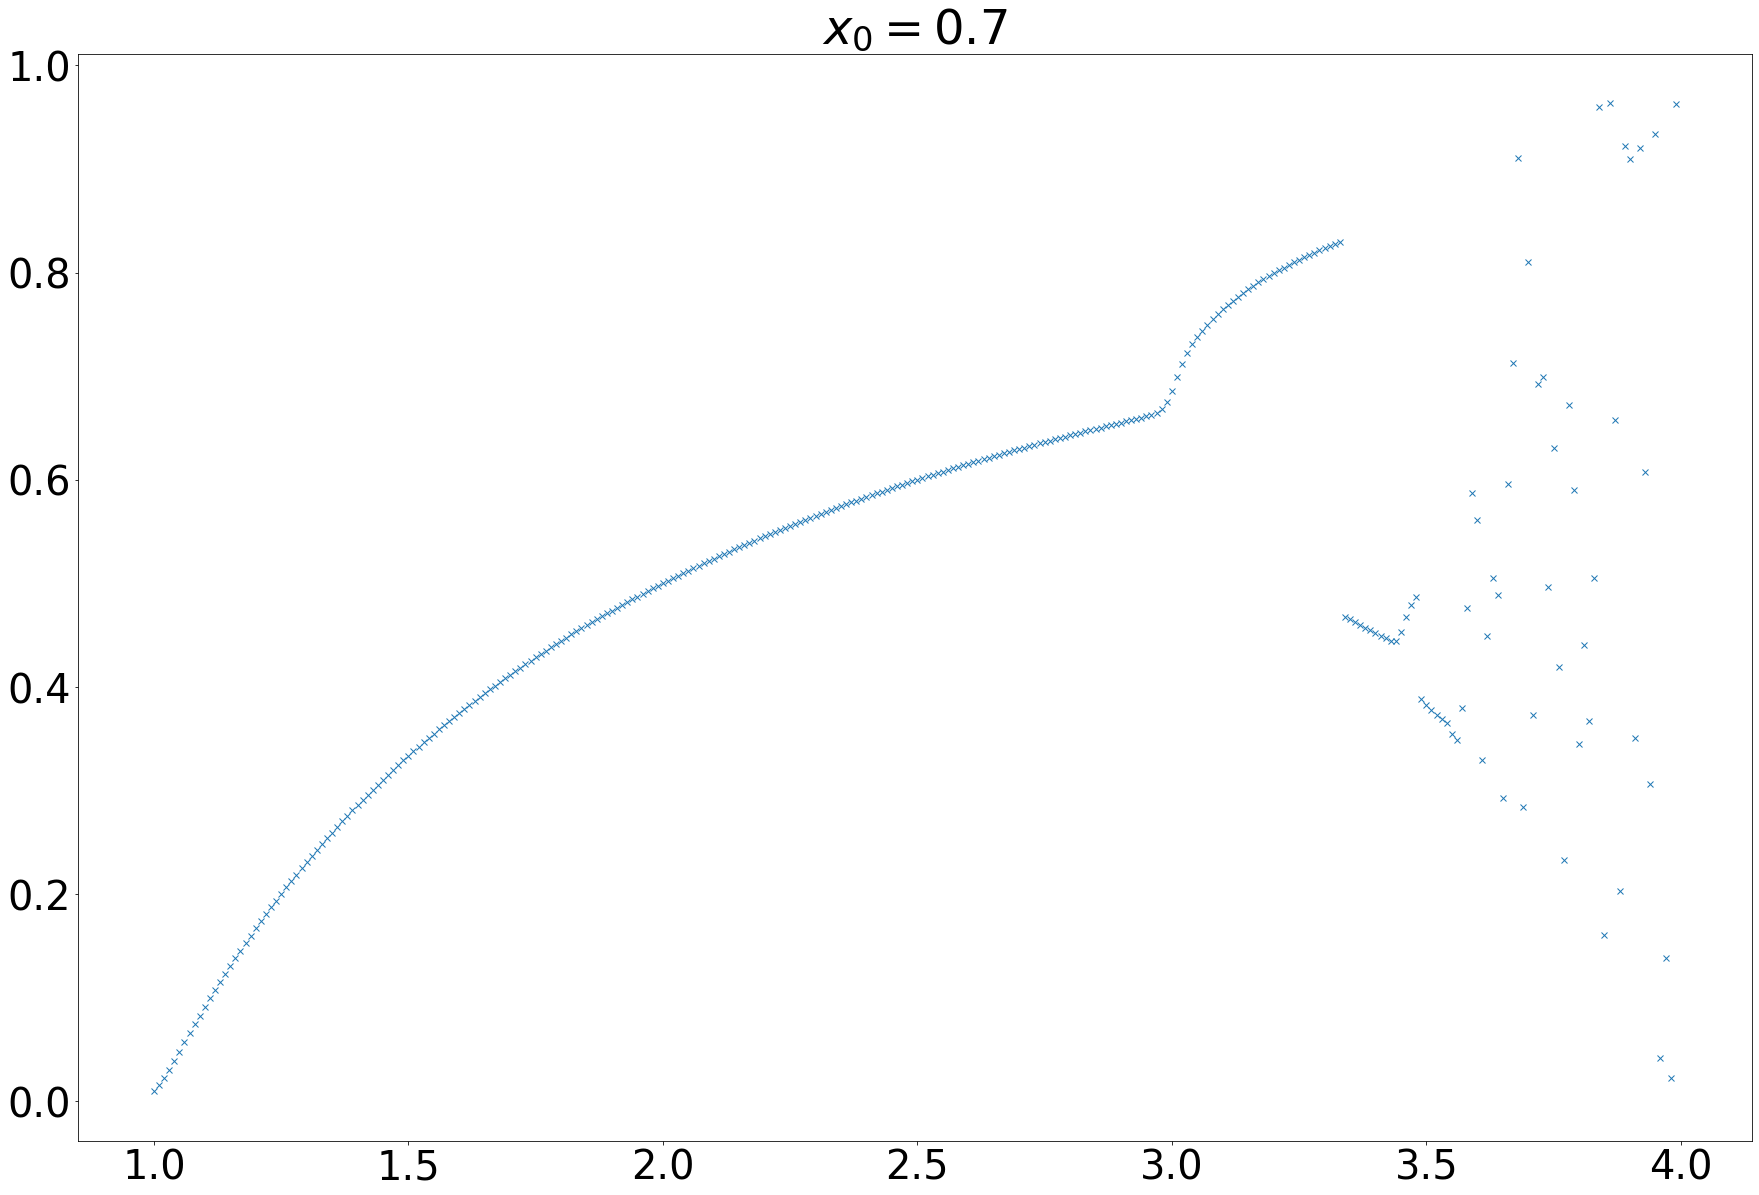

In [18]:
r_space = [q/100 for q in range(100,400,1)]
plt.figure(figsize=(100,60))
plt.rcParams.update({'font.size': 100})
for x0 in [q/1000 for q in range(10,1000,1)]:#[0.1,0.5,0.7]:
    y=[]
    for r in r_space:
        x = x0
        for i in range(100):
            x = next_term(x, r)
        y.append(x)
    plt.plot(r_space, y, "x")
    plt.title("diagram bifurkacji")
plt.show()
for x0 in [0.1,0.5,0.7]:
    plt.figure(figsize=(30,20))
    plt.rcParams.update({'font.size': 40})
    y=[]
    for r in r_space:
        x = x0
        for i in range(100):
            x = next_term(x, r)
        y.append(x)
    plt.plot(r_space, y, "x")
    plt.title(x0)
    plt.title(fr"$x_0={x0}$")
    plt.show()

Zbieżność rozważanego odwzorowania logistycznego jest silnie zależna od przyjętej wartości r, a od wartości $x_0$ zależy w bardzo małym stopniu. Z wyjątkiem kilku wąskich przedziałów rozważane odwzorowanie przestaje być zbieżne dla wartości r większych niż 3.5, a uzyskiwane wartości są pseudo-chaotyczne. Można założyć, że ze względu na brak zbieżności w tym obszarze uzyskane w nim wyniki są silnie zniekształcone przez ich zaokrąglenie.

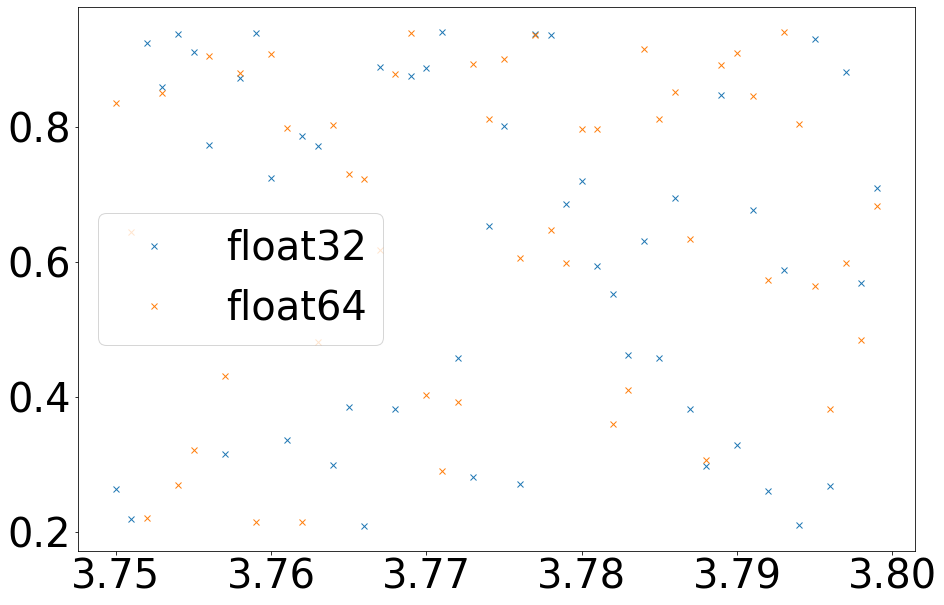

In [19]:
r_space = [q/1000 for q in range(3750,3800,1)]
y = []
x32 = np.float32(0.5)
for r in r_space:
    r = np.float32(r)
    x = x32
    for i in range(100):
        x = np.float32(next_term(x, r))
    assert type(x)==np.float32
    y.append(x)

plt.figure(figsize=(15,10))
plt.plot(r_space, y,  "x" ,label="float32")

y = []
x64 = np.float64(0.5)
for r in r_space:
    r = np.float64(r)
    x = x64
    for i in range(100):
        x = next_term(x, r)
    y.append(x)

plt.plot(r_space, y, "x" ,label="float64")
plt.legend()
plt.show()

Otrzymane wartości znacząco się różnią w zależności od użytej precyzji - można to wyjaśnić wysokim stopniem pseudo-chaotyczności odwzorowania logistycznego w rozważanym obszarze. Jako, że odwzorowanie nie jest zbieżne do żadnej wartości to małe zmiany wyrazów początkowych są propagowane i powiększane z każdym kolejnym obliczonym wyrazem. Powoduje to, że różnice pomiędzy wynikami uzyskanymi za pomocą liczb o różnej dokładności bardzo szybko rosną.

## Wyznaczanie ilości iteracji potrzebnych do osiągnięcia zera

In [23]:
r = np.float32(4)
for x0 in [0.01, 0.25, 0.26, 0.1, 0.4, 0.55, 0.7, 0.71, 0.8]:
    x = np.float32(x0)
    i=0
    while x != 0:
        if i == 1e5: break
        x = np.float32(next_term(x, r))
        i+=1
    if i==1e5:
        print(f"x: {x0:.2f} | nie osiągnięto w {i} iteracji")
    else:
        print(f"x: {x0:.2f} | ilość iteracji po której osiągnięto zero: {i}")

x: 0.01 | ilość iteracji po której osiągnięto zero: 2960
x: 0.25 | nie osiągnięto w 100000 iteracji
x: 0.26 | ilość iteracji po której osiągnięto zero: 1900
x: 0.10 | nie osiągnięto w 100000 iteracji
x: 0.40 | ilość iteracji po której osiągnięto zero: 2406
x: 0.55 | ilość iteracji po której osiągnięto zero: 804
x: 0.70 | ilość iteracji po której osiągnięto zero: 1100
x: 0.71 | ilość iteracji po której osiągnięto zero: 3852
x: 0.80 | nie osiągnięto w 100000 iteracji


$x_0$ | Liczba iteracji w których osiągnięto 0 
--- | ---
0.01 | 2960
0.25 | nie osiągnięto zera w 100 000 iteracji
0.55 | 804
0.70 | 1100
0.71 | 3852

Uzyskane wyniki pokazują, że liczba 0 jest przeważnie osiągana stosunkowo szybko (poniżej 4000 iteracji). Wynik ten jest nieprawdziwy co uzasadniono poniżej.
Aby od niezerowego wyrazu $x_n$ osiągnąć 0 wyraz ten musi doprowadzić do wygenerowania liczby 1 (wtedy $1-x=0$). Prosto zauważyć, że aby uzyskać 1 poprzedni wyraz musi wynieść 0.5 ($4*0.5*(1-0.5)=1$). Można wyliczyć, że aby uzyskać wyraz równy 0.5 poprzedni wyraz musi być niewymierny (obliczenia poniżej). Wartości niewymiernej ze względu na jej nieskończoną reprezentację nie da się przedstawić za pomocą liczby typu float - pomimo tego wartość 0 jest przeważnie osiągana.   
Można stąd wyciągnąć wniosek, że w przypadku tak niestabilnej funkcji, przeprowadzone obliczenia obarczone są znaczącym błędem, więc używanie ich może łatwo doprowadzić do błędnych wniosków.    

Obliczenia:  
      
$0.5=4x(1-x)$  
$0.5=4x-4x^2$
$8x^2-8x+1=0$  
$\Delta=8^2-4*8=32$  
$\sqrt\Delta=\sqrt{32}=4\sqrt2$  
$x_1=\frac {8-4\sqrt2} {16}$  
$x_2=\frac {8+4\sqrt2} {16}$